## Dataset

In [4]:
import os
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm_notebook
import warnings
import IPython.display as ipd
import museval
import mir_eval.separation as eval3

warnings.simplefilter(action='ignore', category=Warning)

model_path = 'MagSpectrogram_model'
model_name = 'model_6'

musdb_train_path = 'data/musdb18/preprocessed/raw/train/'
musdb_valid_path = 'data/musdb18/preprocessed/raw/valid/'
musdb_test_path = 'data/musdb18/preprocessed/raw/test/'

dsd_train_path = 'data/DSD100/preprocessed/train/'
dsd_test_path = 'data/DSD100/preprocessed/test/'

dsd_eval_path = 'EvalData/DSD100'
musdb_eval_path = 'EvalData/MUSDB2018'

mix_name = 'linear_mixture'
target_name = 'voc'

dim_c = 2
dim_f = 2**10
dim_t = 2**6
n_fft=2*(dim_f-1)
hop_factor = 2
hop_length=n_fft//hop_factor
sampling_rate = 44100
sampling_size = hop_length * (dim_t+hop_factor-1)
trim = 5000  # trim each generated sub-signal (noise due to conv zero-padding)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_specs(signal):
    m, p = [], []
    for channel in signal:
        spectrogram = librosa.stft(channel, n_fft=n_fft, center=False, hop_length=hop_length)
        m.append(np.abs(spectrogram))
        p.append(np.angle(spectrogram))
    return np.array(m), np.array(p)

def restore(m, p):
    ft = m * np.exp(1.j*p)
    channels = []
    for ft_c in ft:
        channels.append(librosa.istft(ft_c, center=False, hop_length=hop_length))
    return np.array(channels)


class BssDataset(Dataset):
    def __init__(self, file_path, augment=False):
        self.file_path = file_path
        self.mix_path = file_path + mix_name
        self.target_path = file_path + target_name
        self.augment = augment
    
    def __len__(self):
        return len([name for name in os.listdir(self.mix_path)])
    
    def __getitem__(self, index):
        def coin_toss():
            return np.random.rand() < 0.5 
        
        mix_track = np.load('{0}/{1}.npy'.format(self.mix_path, index))
        target_track = np.load('{0}/{1}.npy'.format(self.target_path, index))
   
        s = np.random.randint(mix_track.shape[1] - sampling_size)
        mix = to_specs(mix_track[:, s:s+sampling_size])[0]
        target = to_specs(target_track[:, s:s+sampling_size])[0]
        
        if self.augment:
            
            # swap left-right channels
            if coin_toss():
                mix = np.array([mix[1], mix[0]])
                target = np.array([target[1], target[0]])
            
            # mixing different songs
            if coin_toss():
                index2 = np.random.randint(len(self))
                target_track2 = np.load('{0}/{1}.npy'.format(self.target_path, index2))

                s = np.random.randint(target_track2.shape[1] - sampling_size)
                target2 = to_specs(target_track2[:, s:s+sampling_size])[0]
                
                mix = mix - target + target2
                target = target2
            
            # scale
            scale = np.random.uniform(low=0.25, high=1.25)
            return torch.tensor(mix)*scale, torch.tensor(target)*scale 
            
        return torch.tensor(mix), torch.tensor(target) 
        

print(sampling_size)
b = BssDataset(dsd_train_path)
b[0][0].shape

66495


torch.Size([2, 1024, 64])

## Modeling

In [8]:
class DenseNet(nn.Module):
    def __init__(self, in_c, l, k, fx, fy, pos_size=None):
        super(DenseNet, self).__init__()
        c = in_c
        self.H = nn.ModuleList()
        
        for i in range(l):
            self.H.append(
                nn.Sequential(
                    nn.BatchNorm2d(c),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=c, out_channels=k, 
                                            kernel_size=(fx, fy), stride=1, padding=(fx//2, fy//2))
                )
            )
            c += k
            
        
        self.pos_f = None if pos_size is None else nn.Parameter(torch.zeros(pos_size))
        
    def forward(self, x):
        if self.pos_f is not None:
            x = x + self.pos_f.unsqueeze(1)
        x_ = self.H[0](x)
        for h in self.H[1:]:
            x = torch.cat((x_, x), 1)
            x_ = h(x)    
            
        return x_
        
    
class MDenseNet(nn.Module):
    def __init__(self, L, l, k, fx, fy, t_scale):
        super(MDenseNet, self).__init__()
        self.n = L//2
        self.mid_dim = (dim_f//2**self.n, dim_t//2**len(t_scale))
        
        self.ds_dense = nn.ModuleList()
        self.ds = nn.ModuleList()
        for i in range(self.n):
            self.ds_dense.append(DenseNet(dim_c if i==0 else k, l, k, fx, fy, pos_size=dim_f//2**i))
            
            scale = (2,2) if i in t_scale else (2,1)
            self.ds.append(
                nn.Sequential(
                    nn.BatchNorm2d(k),
                    nn.Conv2d(in_channels=k, out_channels=k, kernel_size=1, stride=1),
                    nn.AvgPool2d(kernel_size=scale, stride=scale)
                )
            )
        
        
        self.mid_dense = DenseNet(k, l, k, fx, fy, pos_size=dim_f//2**self.n)
        
        self.us_dense = nn.ModuleList()
        self.us = nn.ModuleList()
        for i in range(self.n):
            self.us_dense.append(DenseNet(2*k, l, k, fx, fy, pos_size=dim_f//2**(self.n-1 - i)))
            
            scale = (2,2) if i in self.n-1 - t_scale else (2,1)
            self.us.append(
                nn.Sequential(
                    nn.BatchNorm2d(k),
                    nn.ConvTranspose2d(in_channels=k, out_channels=k, kernel_size=scale, stride=scale),
                )
            )
        
        self.pos_f = nn.Parameter(torch.zeros(dim_f))
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Conv2d(in_channels=k, out_channels=dim_c, kernel_size=1, stride=1)
        )
        
        
    def forward(self, x):
        
        ds_outputs = []
        for i in range(self.n):
            x = self.ds_dense[i](x)
            ds_outputs.append(x)
            x = self.ds[i](x)
        
        x = self.mid_dense(x)

        for i in range(self.n):
            x = self.us[i](x)
            x = torch.cat((x, ds_outputs[-i-1]), 1)
            x = self.us_dense[i](x)
        
        x = x + self.pos_f.unsqueeze(1)
        return self.final_conv(x)
    
    
class hp:
    num_layers = 13
    num_d_layers = 4
    growth_rate = 15
    filter_size_x = 3
    filter_size_y = 3
    t_scale = np.array([1,3,5])

## Training 

In [23]:
model = MDenseNet(hp.num_layers, hp.num_d_layers, hp.growth_rate, hp.filter_size_x, hp.filter_size_y, hp.t_scale).to(device)

train_set = BssDataset(file_path=dsd_train_path, augment=True)
train_iter = DataLoader(train_set, batch_size=4, shuffle=True)

loss_trace = []

def init_weights(model, ckpt, epoch=0):
    if ckpt==0:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
    else:
        optim.load_state_dict(torch.load('{0}/{1}/{2}_optim.pt'.format(model_path, model_name, target_name)))
        if epoch==0:
            model.load_state_dict(torch.load('{0}/{1}/{2}.pt'.format(model_path, model_name, target_name)))
        else:
            model.load_state_dict(torch.load('{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, epoch)))

criterion = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)

lr_decay = 0.9997
lr_func = lambda e: 1 if e < 2000 else 0.1 
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

sum(p.numel() for p in model.parameters() if p.requires_grad) 

321200

In [26]:
num_epochs = 20000
ckpt_min_epoch = 1500
ckpt_steps = 500

epoch 3861
0.14325621530413626


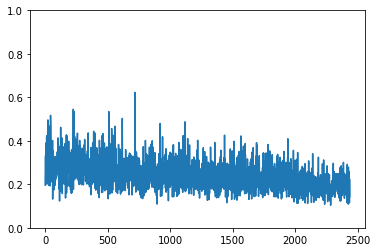

KeyboardInterrupt: 

In [31]:
init_weights(model, 1)

start_e = 3860
for e in range(start_e, num_epochs):
    model.train()
    loss_sum = 0
    for mix, tar in tqdm_notebook(train_iter):
        mix = mix.to(device)
        tar = tar.to(device)
        y_hat = model(mix)
        loss = criterion(y_hat, tar)
        loss.backward()
        optim.step()
        optim.zero_grad()
        loss_sum += loss.item() * mix.shape[0]
        
    scheduler.step()
    
    ipd.clear_output(wait=True)
    print('epoch' , e)

    epoch_avg_loss = loss_sum / len(train_set)
    loss_trace.append(epoch_avg_loss)
    print(epoch_avg_loss)
    plt.plot(loss_trace)
    plt.ylim(0, 1.0)
    plt.show()

    torch.save(optim.state_dict(), '{0}/{1}/{2}_optim.pt'.format(model_path, model_name, target_name))
    torch.save(model.state_dict(), '{0}/{1}/{2}.pt'.format(model_path, model_name, target_name))
    if e>=ckpt_min_epoch and e%ckpt_steps==0:
        torch.save(model.state_dict(), '{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, e))
    
    

In [ ]:
plt.plot(model.pos_f)
plt.show()

for d in model.ds_dense:
    plt.plot(d.pos_f)

### Generate targets for all test tracks

In [32]:
# stereo version, shape=(num_intervals, 2, f, t)
def preprocess_track(track_path, s, d):
    y, sr = librosa.load(track_path, mono=False, sr=None, offset=s, duration=d)
    n_sample = y.shape[1]
    
    gen_size = sampling_size-2*trim
    pad = gen_size - n_sample%gen_size
    y_p = np.concatenate((np.zeros((2,trim)), y, np.zeros((2,pad)), np.zeros((2,trim))), 1)
    
    mag, phase = [], []
    i = 0
    while i < n_sample + pad:
        specs = to_specs(y_p[:, i:i+sampling_size])
        mag.append(specs[0])
        phase.append(specs[1])
        i += gen_size

    return torch.tensor(mag), np.array(phase), sr, pad


def separate(model, mix_path, s=0.0, d=None):
    mix_mag, mix_phase, mix_sr, pad_len = preprocess_track(mix_path, s, d)
   
    # create batches
    batch_size = 4  # even integer for stereo 
    i = 0
    num_intervals = mix_mag.shape[0]
    batches = []
    while i < num_intervals:
        batches.append(mix_mag[i:i+batch_size])
        i = i + batch_size

    # obtain estimated target spectrograms
    tar_mag = None
    with torch.no_grad():
        for batch in tqdm_notebook(batches):
            t_mag = model(batch.to(device))

            if tar_mag is None:
                tar_mag = t_mag.detach().cpu()
            else:
                tar_mag = torch.cat((tar_mag, t_mag.detach().cpu()), 0)

    # reconstruct vocal signal
    tar_mag = tar_mag.numpy()
    tar_signal = np.array([[],[]])
    for i in range(len(tar_mag)):
        tar_signal = np.concatenate((tar_signal, np.array(restore(tar_mag[i], mix_phase[i]))[:, trim:-trim]), 1)

    tar_signal = tar_signal[:, :-pad_len]
    
    return tar_signal

In [6]:
init_weights(model, 1)

for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    m_path = '{0}/test_mix/{1}.wav'.format(dsd_eval_path, track_name)
    t_path = '{0}/{1}/estimates_voc-acc/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)

    tar_signal = separate(model, m_path)
    
    librosa.output.write_wav(t_path, np.array(tar_signal, np.float32), sampling_rate)

## Evaluation

In [33]:
def mean_nan(a):
    return a[~np.isnan(a)].mean()


def dsd_sdr(ref, est, framewise=True):
    if framewise:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images_framewise(ref, est)
    else:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images(ref, est)
    return mean_nan(sdr[0])

def musdb_sdr(ref, est, sr):
    sdr, isr, sir, sar, perm = eval4.metrics.bss_eval(ref, est, window=sr, hop=sr)
    return mean_nan(sdr[0])

### Voc

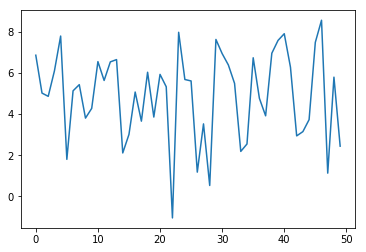

Global values..

SDR mean: 4.9021942762378385
SDR median: 5.371768174260826


In [9]:
import math
import statistics as stats

SDR = []
for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    
    ref, sr = librosa.load('{0}/test_sources/{1}/{2}.wav'.format(dsd_eval_path, track_name, target_name), mono=False, sr=None)

    est_path = '{0}/{1}/estimates_voc-acc/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)
    est, sr = librosa.load(est_path, mono=False, sr=None)
 
    
    sdr = dsd_sdr(np.array([ref.T]), np.array([est.T]))
    
    print(sdr)
    SDR.append(sdr)

    
    ipd.clear_output(wait=True)
    plt.plot(SDR)
    plt.show()

    print('Global values..\n')
    print('SDR mean:', stats.mean(SDR))
    print('SDR median:', stats.median(SDR))


## Evaluate sub-track SDR

In [44]:
track_name = 'test_{0:02}'.format(22)
s = 0
d = None

ref, sr = librosa.load('{0}/test_voc-acc/{1}/{2}.wav'.format(dsd_eval_path, track_name, target_name), mono=False, sr=None, offset=s, duration=d)

# est_path = '{0}/{1}/estimates_voc-acc/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)
# est, sr = librosa.load(est_path, mono=False, sr=None, offset=s, duration=d)

init_weights(model, 1)
est = separate(model, '{0}/test_mix/{1}.wav'.format(dsd_eval_path, track_name), s=s, d=d)

#ipd.Audio(est, rate=sr)


In [45]:
ref_ = np.array([ref.T])
est_ = np.array([est.T])

sdr = dsd_sdr(ref_, est_, framewise=True)

print(sdr)

-8.12119316950949


### Create estimates folders

In [17]:
os.mkdir('{0}/{1}/estimates_voc-acc'.format(model_path, model_name))
for i in tqdm_notebook(range(50)):
    track_name = 'test_{0:02}'.format(i)
    p = '{0}/{1}/estimates_voc-acc/test_{2:02}'.format(model_path, model_name, i)
    os.mkdir(p)